In [734]:
from pybit import HTTP, WebSocket
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import requests
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque
import time

import os
import random

In [735]:
session = HTTP(
    endpoint='https://api.bybit.com',
    api_key='2KxKcZtN9yypt4qpoT',
    api_secret='b9SgnjdaoA0zy9ymMyI21g76OCVPb32Kvm7N'
)

2021-02-19 09:08:39 - pybit - INFO - Initializing HTTP session.


In [736]:
session.latest_information_for_symbol(symbol='BTCUSD')

{'ret_code': 0,
 'ret_msg': 'OK',
 'ext_code': '',
 'ext_info': '',
 'result': [{'symbol': 'BTCUSD',
   'bid_price': '53027',
   'ask_price': '53027.5',
   'last_price': '53027.50',
   'last_tick_direction': 'PlusTick',
   'prev_price_24h': '51839.50',
   'price_24h_pcnt': '0.022916',
   'high_price_24h': '53088.00',
   'low_price_24h': '50684.00',
   'prev_price_1h': '52710.00',
   'price_1h_pcnt': '0.006023',
   'mark_price': '52926.50',
   'index_price': '52905.24',
   'open_interest': 2146242135,
   'open_value': '14616.80',
   'total_turnover': '66018556.96',
   'turnover_24h': '112347.61',
   'total_volume': 920616613608,
   'volume_24h': 5838981207,
   'funding_rate': '0.001137',
   'predicted_funding_rate': '0.001852',
   'next_funding_time': '2021-02-19T16:00:00Z',
   'countdown_hour': 2}],
 'time_now': '1613743720.721972'}

In [737]:
bitcoin_data = pd.read_csv('binance_BTCUSDT_15min.csv')
# bitcoin_data['timestamp'] = bitcoin_data['timestamp'].str.replace('.000', '')
bitcoin_data['date'] = pd.to_datetime(bitcoin_data['timestamp']).dt.date
bitcoin_data['time'] = pd.to_datetime(bitcoin_data['timestamp']).dt.time
bitcoin_data['time'] = bitcoin_data['time'].astype('str').str.replace(':','').str[0:-2]
timestamps = []

for timestamp in bitcoin_data['timestamp']:
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f'):
        try:
            timestamps.append(datetime.strptime(timestamp, fmt).timestamp())
        except ValueError:
            pass
        # raise ValueError('no valid date format found for ' + timestamp)

bitcoin_data['timestamp'] = timestamps
bitcoin_data = bitcoin_data[['timestamp', 'date', 'time', 'open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT']]
bitcoin_data = bitcoin_data.set_index('date')
bitcoin_data.columns = ['timestamp', 'time', 'open', 'high', 'low', 'close', 'volume']
bitcoin_data['ticker'] = 'BTC'

In [738]:
bitcoin_data

,timestamp,time,open,high,low,close,volume,ticker
date,,,,,,,,
2017-08-17,1.502957e+09,0400,4261.48,4280.56,4261.48,4261.48,2.189061,BTC
2017-08-17,1.502958e+09,0415,4261.48,4270.41,4261.32,4261.45,9.119865,BTC
2017-08-17,1.502959e+09,0430,4280.00,4310.07,4267.99,4310.07,21.923552,BTC
2017-08-17,1.502960e+09,0445,4310.07,4313.62,4291.37,4308.83,13.948531,BTC
2017-08-17,1.502960e+09,0500,4308.83,4328.69,4304.31,4304.31,5.101153,BTC
...,...,...,...,...,...,...,...,...
2021-02-18,1.613677e+09,1430,51877.50,52285.00,51870.00,52173.97,979.916040,BTC
2021-02-18,1.613678e+09,1445,52173.97,52280.00,51971.03,52233.43,748.124638,BTC
2021-02-18,1.613678e+09,1500,52233.43,52260.00,51852.10,52018.26,787.951975,BTC


In [739]:
bitcoin_data

,timestamp,time,open,high,low,close,volume,ticker
date,,,,,,,,
2017-08-17,1.502957e+09,0400,4261.48,4280.56,4261.48,4261.48,2.189061,BTC
2017-08-17,1.502958e+09,0415,4261.48,4270.41,4261.32,4261.45,9.119865,BTC
2017-08-17,1.502959e+09,0430,4280.00,4310.07,4267.99,4310.07,21.923552,BTC
2017-08-17,1.502960e+09,0445,4310.07,4313.62,4291.37,4308.83,13.948531,BTC
2017-08-17,1.502960e+09,0500,4308.83,4328.69,4304.31,4304.31,5.101153,BTC
...,...,...,...,...,...,...,...,...
2021-02-18,1.613677e+09,1430,51877.50,52285.00,51870.00,52173.97,979.916040,BTC
2021-02-18,1.613678e+09,1445,52173.97,52280.00,51971.03,52233.43,748.124638,BTC
2021-02-18,1.613678e+09,1500,52233.43,52260.00,51852.10,52018.26,787.951975,BTC


In [740]:
def load_data(filename, n_steps=100, scale=True, shuffle=True, lookup_step=1, split_by_date=True,test_size=0.2, feature_columns=['time', 'open', 'high', 'low', 'close', 'volume']):
    """
    Loads data from the BTC historical data from binance, as well as scaling, shuffling, normalizing and splitting.
    Params:
        data (str): the filename of the data you want to load
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    result = {}

    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y%m%d')
    df['time'] = pd.to_datetime(df['timestamp']).dt.strftime('%H%M')
    timestamps = []

    for timestamp in df['timestamp']:
        for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f'):
            try:
                timestamps.append(datetime.strptime(timestamp, fmt).timestamp())
            except ValueError:
                pass

    df['timestamp'] = timestamps
    df = df[['timestamp', 'date', 'time', 'open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT', 'volume_BTCUSDT']]
    df = df.set_index('timestamp')
    df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    df['ticker'] = 'BTC'

    # We will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "timestamp" not in df.columns:
        df["timestamp"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["timestamp"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # add to result
    result['last_sequence'] = last_sequence

    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]

    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]

    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]

    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [741]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [742]:
# Filename of the BTCUSDT data
filename = 'binance_BTCUSDT_hour.csv'

# Window size or the sequence length (number of candles)
N_STEPS = 50

# Lookup step, 1 is the next candle
LOOKUP_STEP = 1

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

# date now
date_now = time.strftime("%Y-%m-%d-$H-%M")

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = LSTM

# 256 LSTM neurons
UNITS = 256

# 40% dropout
DROPOUT = 0.4

# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5

# Amazon stock market
ticker = "BTC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"


In [743]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [744]:
data = load_data(filename, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

In [745]:
# save the dataframe
data["df"].to_csv(ticker_data_filename)

In [746]:
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS, dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

AlreadyExistsError: Another profiler is running.

In [604]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.figure(figsize=(28,14))
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.xticks(rotation=45)
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [605]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [606]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [607]:
# load optimal model weights from results folder
model_name = '2021-02-19_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-200-step-50-layers-2-units-256'
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [608]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [609]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [610]:
# predict the future price
future_price = predict(model, data)

In [611]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [612]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 50 days is 66372.01$
huber_loss loss: 5.707038508262485e-05
Mean Absolute Error: 3584.9570797533725
Accuracy score: 0.9323671497584541
Total buy profit: 408796.99078125006
Total sell profit: 116243.4726171875
Total profit: 525040.4633984376
Profit per trade: 2536.427359412742


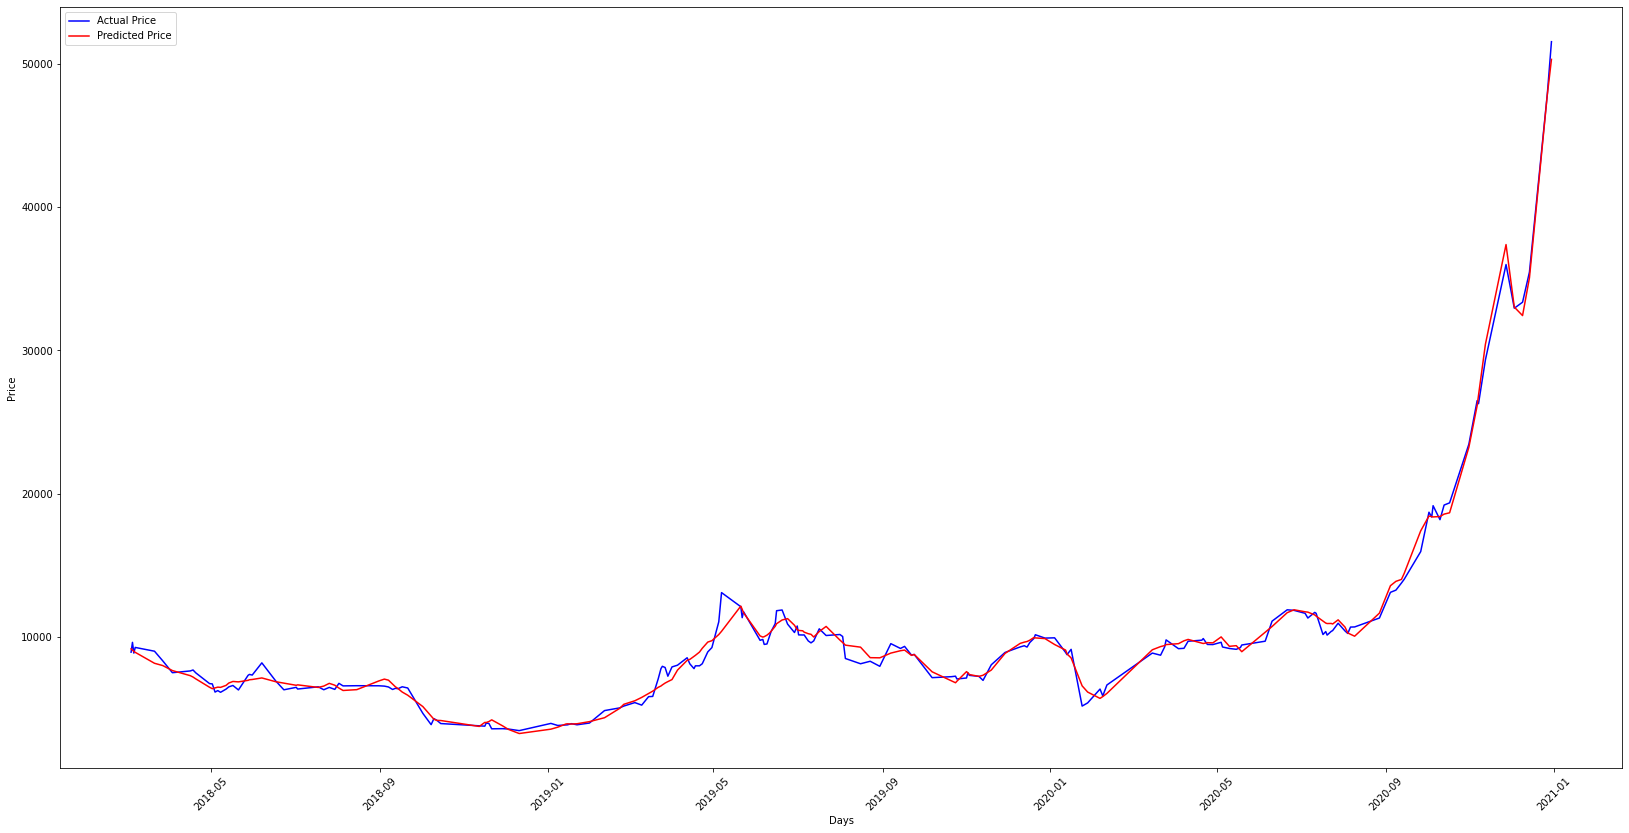

In [613]:
# plot true/pred prices graph
plot_graph(final_df)

In [617]:
final_df.tail(20)

,timestamp,open,high,low,close,volume,ticker,close_50,true_close_50,buy_profit,sell_profit
date,,,,,,,,,,,
2020-09-08,2020-09-08,10373.45,10438.00,9850.00,10126.65,73491.878418,BTC,13879.851562,13266.40,3753.201563,0.0
2020-09-12,2020-09-12,10387.89,10477.97,10269.25,10440.92,35379.153096,BTC,14014.312500,13761.50,3573.392500,0.0
2020-09-14,2020-09-14,10332.84,10750.00,10212.34,10671.77,67059.291361,BTC,14431.797852,14023.53,3760.027852,0.0
2020-09-26,2020-09-26,10686.57,10820.94,10644.68,10728.60,28420.836659,BTC,17405.654297,15957.00,6677.054297,0.0
2020-10-02,2020-10-02,10619.13,10664.64,10374.00,10570.40,50130.393705,BTC,18440.689453,18703.80,7870.289453,0.0
2020-10-04,2020-10-04,10542.07,10696.87,10517.87,10666.63,23212.001595,BTC,18396.355469,18368.00,7729.725469,0.0
2020-10-05,2020-10-05,10666.62,10798.00,10615.64,10792.21,34025.761653,BTC,18376.679688,19160.01,7584.469688,0.0
2020-10-10,2020-10-10,11050.64,11491.00,11050.51,11293.22,43648.036943,BTC,18403.003906,18184.99,7109.783906,0.0
2020-10-13,2020-10-13,11528.24,11557.00,11300.00,11420.56,42205.283709,BTC,18572.046875,19204.09,7151.486875,0.0
